In [29]:
import numpy as np
import h5py
from scipy import optimize
from scipy import signal
import matplotlib.pyplot as plt


In [30]:
Atom = "O"
Path = r"X:\RIXS\Hirsbrunner_e19715"

In [31]:
def MakeFileName(scanNumber):
    global Atom
    if scanNumber < 10:
        fileName = Atom + "_" + "000" + str(scanNumber)
    elif scanNumber < 100:
        fileName = Atom + "_" + "00" + str(scanNumber)
    elif scanNumber < 1000:
        fileName = Atom + "_" + "0" + str(scanNumber)
    else:
        fileName = Atom + "_" + str(scanNumber)
    return fileName

def GetData(scanNumber):
    global Path
    f1 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d1.h5", "r")
    f2 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d2.h5", "r")
    f3 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d3.h5", "r")
    ccd1 = f1["entry"]["analysis"]["spectrum"][()]
    ccd2 = f2["entry"]["analysis"]["spectrum"][()]
    ccd3 = f3["entry"]["analysis"]["spectrum"][()]
    Energy = np.mean(f1["entry"]["instrument"]["NDAttributes"]["PhotonEnergy"][()])
    
    return Energy,ccd1,ccd2,ccd3

def Gaussian_amp(x,xc,fwhm,amp):
    return amp*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

def fitElastic(data):

    pixel = np.arange(len(data))

    peaks, _ = signal.find_peaks(
        data, height=np.max(data) / 2, width=3
    )

    popt, pcov = optimize.curve_fit(
        Gaussian_amp,
        pixel,
        data,
        p0=[peaks[-1], 10, np.max(data)/2],
    )

    return popt

def findElastic(scanNumber):
    Energy,ccd1,ccd2,ccd3=GetData(scanNumber)
    xc1,fwhm1,amp1 = fitElastic(ccd1)
    xc2,fwhm2,amp2 = fitElastic(ccd2)
    xc3,fwhm3,amp3 = fitElastic(ccd3)

    return Energy,np.array([xc1,xc2,xc3])

In [32]:
en = np.array([])
peaks = np.array([])
for x in range(104,390):
    energy,peak=findElastic(x)
    en = np.append(en,energy)
    peaks = np.append(peaks,peak)

peaks= peaks.reshape(int(len(peaks)/3),3)

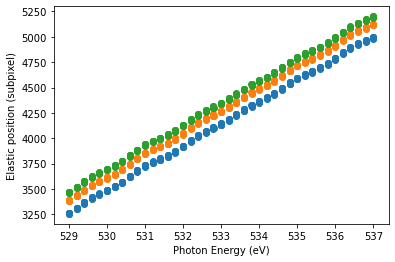

In [33]:
plt.figure()
plt.plot(en,peaks[:,0],'o')
plt.plot(en,peaks[:,1],'o')
plt.plot(en,peaks[:,2],'o')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Elastic position (subpixel)')
plt.savefig('1.png',dpi=600)

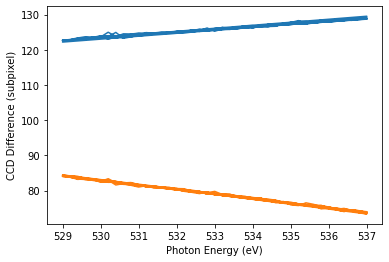

In [34]:
plt.figure()
plt.plot(en,peaks[:,1]-peaks[:,0])
plt.plot(en,peaks[:,2]-peaks[:,1])
plt.xlabel('Photon Energy (eV)')
plt.ylabel('CCD Difference (subpixel)')
plt.savefig('2.png',dpi=600)

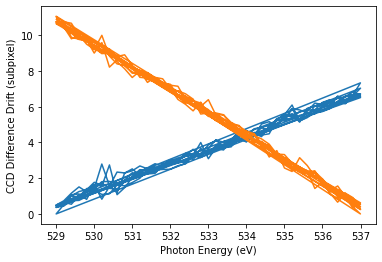

In [35]:
plt.figure()
plt.plot(en,peaks[:,1]-peaks[:,0]-(peaks[0,1]-peaks[0,0]))
plt.plot(en,peaks[:,2]-peaks[:,1]-(peaks[0,2]-peaks[0,1]))
plt.xlabel('Photon Energy (eV)')
plt.ylabel('CCD Difference Drift (subpixel)')
plt.savefig('3.png',dpi=600)

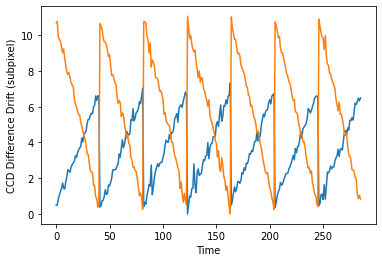

In [37]:
plt.figure()
plt.plot(peaks[:,1]-peaks[:,0]-(peaks[0,1]-peaks[0,0]))
plt.plot(peaks[:,2]-peaks[:,1]-(peaks[0,2]-peaks[0,1]))
plt.xlabel('Time')
plt.ylabel('CCD Difference Drift (subpixel)')
plt.savefig('4.png',dpi=600)

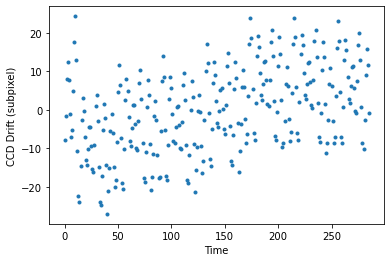

In [38]:
[slope,inter] = np.polyfit(en,peaks[:,0],1)
plt.plot(peaks[:,0]-(en*slope+inter),'.')
plt.xlabel('Time')
plt.ylabel('CCD Drift (subpixel)')
plt.savefig('5.png',dpi=600)

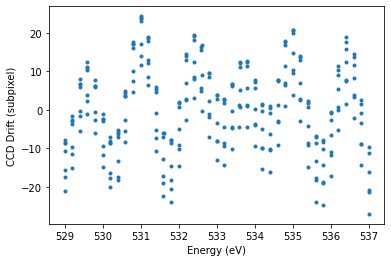

In [40]:
[slope,inter] = np.polyfit(en,peaks[:,0],1)
plt.plot(en,peaks[:,0]-(en*slope+inter),'.')
plt.xlabel('Energy (eV)')
plt.ylabel('CCD Drift (subpixel)')
plt.savefig('6.png',dpi=600)